In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import torch
from torchvision import datasets, transforms
import os
from tqdm import tqdm
from scipy.stats import randint
import joblib
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Данный метод не приемлет преобразования которые мы делали для нейросеток, поэтому скачиваем данные заново
img_size = (32, 32)
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])

# Загрузка данных
def load_data(folder_path):
    dataset = datasets.ImageFolder(folder_path, transform=transform)
    X, y = [], []
    for img, label in tqdm(dataset):
        img_np = img.numpy()
        flat_img = img_np.flatten()
        X.append(flat_img)
        y.append(label)
    return np.array(X), np.array(y)

In [3]:
train_path = r"C:\Users\kalmy\Documents\Машинное обучение\PKLot_Dataset\create data\2_tmptest"
val1_path  = r"C:\Users\kalmy\Documents\Машинное обучение\PKLot_Dataset\create data\1_tmptest3"
val2_path  = r"C:\Users\kalmy\Documents\Машинное обучение\PKLot_Dataset\create data\selected"
test_path  = r"C:\Users\kalmy\Documents\Машинное обучение\PKLot_Dataset\create data\0_tmptest2"

X_train, y_train = load_data(train_path)
X_val1, y_val1   = load_data(val1_path)
X_val2, y_val2   = load_data(val2_path)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:24<00:00, 30.82it/s]


In [4]:
X_val = np.concatenate((X_val1, X_val2), axis=0)
y_val = np.concatenate((y_val1, y_val2), axis=0)

In [5]:
pca = PCA(n_components=100)  # вместо 32*32*3 признаков оставим 100
X_train_reduced = pca.fit_transform(X_train)

In [25]:
X_val_reduced = pca.transform(X_val)

In [ ]:
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 10), 
}

In [ ]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# RandomizedSearchCV (5 итераций, можно увеличить)
search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=15,                 # количество случайных комбинаций
    scoring='accuracy',        # метрика
    cv=3,                      # кросс-валидация
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Подбор по обучающим данным
search.fit(X_train_reduced, y_train)
# лучшее решение:
# {'bootstrap': True, 'max_depth': 29, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 171}

In [ ]:
best_model = search.best_estimator_
print("Лучшие параметры:\n", search.best_params_)

# Оценка на валидации
y_pred = best_model.predict(X_test_reduced)
print(classification_report(y_val, y_pred))

In [ ]:
test_path = r"C:\Users\kalmy\Documents\Машинное обучение\PKLot_Dataset\create data\A"
X_test, y_test = load_data(test_path)
X_ttest_reduced = pca.transform(X_test)

In [ ]:
y_pred = best_model.predict(X_ttest_reduced)

print("\nКлассификационный отчёт:")
print(classification_report(y_test, y_pred, target_names=["occupied", "empty"]))

In [ ]:
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

In [19]:
# Сохраняем модель
joblib.dump(clf, "random_forest_model2.pkl")

['random_forest_model2.pkl']

In [46]:
# Загружаем модель
clf = joblib.load("random_forest_model2.pkl")

### Просто рандомный лес

In [39]:
clf = RandomForestClassifier(
    n_estimators=100,        # увеличение не приводит к лучшим результатам
    max_depth=25,            # не даем деревьям перерастать
    min_samples_split=4,     # чтобы не переобучался
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train_reduced, y_train)

RandomForestClassifier(max_depth=25, min_samples_split=4, n_jobs=-1,
                       random_state=42)

In [28]:
def get_metrics(y_true, y_pred):
    print("\nКлассификационный отчёт:")
    print(classification_report(y_true, y_pred, target_names=["occupied", "empty"]))
    print("Accuracy = ", accuracy_score(y_true, y_pred))
    print("F-1 мера = ", f1_score(y_true, y_pred))
    print("Precision = ", precision_score(y_true, y_pred))
    print("Recall = ", recall_score(y_true, y_pred))

In [47]:
y_pred = clf.predict(X_val_reduced)
get_metrics(y_val, y_pred)


Классификационный отчёт:
              precision    recall  f1-score   support

    occupied       0.90      0.92      0.91      9472
       empty       0.93      0.91      0.92     10244

    accuracy                           0.91     19716
   macro avg       0.91      0.91      0.91     19716
weighted avg       0.91      0.91      0.91     19716

Accuracy =  0.9143842564414688
F-1 мера =  0.9166995657323332
Precision =  0.9269461077844311
Recall =  0.9066770792659118


In [30]:
for i in range(1, 7):
    img_path = r"C:\Users\kalmy\Documents\Машинное обучение\доп картинки\empty_lot" + str(i)+".png"
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)
    img_flat = img_tensor.numpy().flatten().astype(np.float16).reshape(1, -1)
    pred = clf.predict(pca.transform(img_flat))[0]
    class_names = ["occupied", "empty"]  # Порядок такой, как в ImageFolder
    print(f"Предсказание: {class_names[pred]}")
print("_"*40)
for i in range(1, 7):
    img_path = r"C:\Users\kalmy\Documents\Машинное обучение\доп картинки\occupied_lot" + str(i)+".png"
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)
    img_flat = img_tensor.numpy().flatten().astype(np.float16).reshape(1, -1)
    pred = clf.predict(pca.transform(img_flat))[0]
    class_names = ["occupied", "empty"]  # Порядок такой, как в ImageFolder
    print(f"Предсказание: {class_names[pred]}")

Предсказание: empty
Предсказание: empty
Предсказание: empty
Предсказание: empty
Предсказание: occupied
Предсказание: occupied
________________________________________
Предсказание: occupied
Предсказание: occupied
Предсказание: occupied
Предсказание: occupied
Предсказание: occupied
Предсказание: occupied


#### И тест

In [ ]:
X_test, y_test = load_data(test_path)

In [ ]:
X_test_reduced = pca.transform(X_test)

In [51]:
y_pred = clf.predict(X_test_reduced)
get_metrics(y_test, y_pred)


Классификационный отчёт:
              precision    recall  f1-score   support

    occupied       0.99      0.80      0.88      3621
       empty       0.78      0.98      0.87      2550

    accuracy                           0.88      6171
   macro avg       0.88      0.89      0.88      6171
weighted avg       0.90      0.88      0.88      6171

Accuracy =  0.8770053475935828
F-1 мера =  0.868616929202008
Precision =  0.7775023241400681
Recall =  0.983921568627451


In [58]:
def get_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['occupied', 'empty'])
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, values_format='d', cmap='Blues')
    plt.title("Confusion Matrix on test")
    plt.tight_layout()
    plt.savefig('1.png', dpi=300, bbox_inches='tight')
    plt.show()

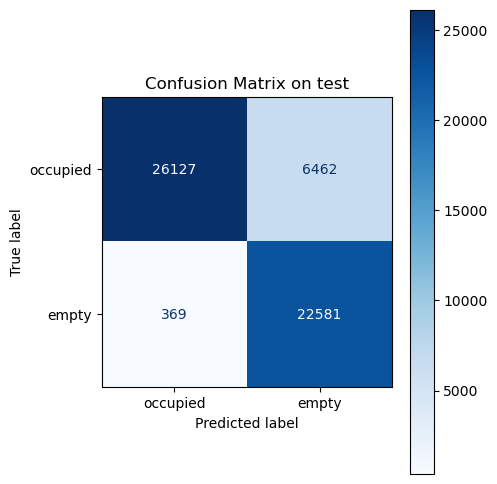

In [59]:
get_matrix(y_test, y_pred)